# GSE205506 Data Preprocessing

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import scipy.io as sio
import anndata as ad
import os as os
import seaborn as sns
from load_10X_matrices import load_10X_matrices

## 0. Loading Data

In [2]:
# Takes ~10-11 min to load
directory = '/home/data/PanCanSC/CRC/GEO/GSE205506/'
adata = load_10X_matrices('/home/data/PanCanSC/CRC/GEO/GSE205506/')
print(adata)

Loading GSM6213961_Colon_MGI_151_v3_
Loading GSM6213985_Colon_MGI_292_v3_
Loading GSM6213966_Colon_182_v2_
Loading GSM6213960_Colon_MGI_141_v2_
Loading GSM6213970_Colon_MGI_213_v3_
Loading GSM6213983_Colon_MGI_283_v3_
Loading GSM6213957_Colon_MGI_112_v3_
Loading GSM6213981_Colon_MGI_281_v3_
Loading GSM6213977_Colon_MGI_261_v3_
Loading GSM6213964_Colon_172_v3_
Loading GSM6213986_Colon_MGI_301_v3_
Loading GSM6213969_Colon_MGI_211_v3_
Loading GSM6213959_Colon_MGI_122_v3_
Loading GSM6213979_Colon_MGI_272_v3_
Loading GSM6213984_Colon_MGI_291_v3_
Loading GSM6213995_Colon_MGI_333_v3_
Loading GSM6213956_Colon_MGI_111_v2_
Loading GSM6213972_Colon_MGI_241_v3_
Loading GSM6213989_Colon_MGI_311_v3_
Loading GSM6213971_Colon_MGI_233_v3_
Loading GSM6213978_Colon_MGI_271_v3_
Loading GSM6213991_Colon_MGI_313_v3_
Loading GSM6213962_Colon_MGI_152_v3_
Loading GSM6213965_Colon_181_v2_
Loading GSM6213967_Colon_MGI_191_v3_
Loading GSM6213974_Colon_MGI_251_v3_
Loading GSM6213982_Colon_MGI_282_v3_
Loading GSM62

/home/xinghua/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
adata.obs_names_make_unique

<bound method AnnData.obs_names_make_unique of AnnData object with n_obs × n_vars = 324020 × 33538
    obs: 'sample_ID'>

#### Extracting sample src & patient ID from sample ID

In [4]:
sampleID = adata.obs['sample_ID']
short = [x.split('_')[3] for x in sampleID]
adata.obs['sample_src'] = [x[-1] for x in short]
adata.obs['patient_ID'] = [x[:-1] for x in short]

In [5]:
adata.shape

(324020, 33538)

### Write the GSE205506 AnnData obj 
Save time for future experiments

In [6]:
#write to file
adata.write('/home/data/PanCanSC/CRC/GEO/GSE205506/GSE205506.h5ad')

In [4]:
adata = sc.read('/home/data/PanCanSC/CRC/GEO/GSE205506/GSE205506.h5ad')

/home/xinghua/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [5]:
print ("Dimention of adata: " + str(adata.shape))
print ("columns for adata.obs: " + str(adata.obs.columns))

Dimention of adata: (324020, 33538)
columns for adata.obs: Index(['sample_ID', 'sample_src', 'patient_ID'], dtype='object')


## 1. Basic Filtering

In [6]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.3 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.2.2 statsmodels==0.13.5 python-igraph==0.10.4 pynndescent==0.5.7


#### Removing cells expressing <500 || >5000 genes:

In [11]:
# removing cells expressing <500 || >5000 genes
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_cells(adata, max_genes=5000)

filtered out 132 cells that have less than 500 genes expressed


In [12]:
print ("Dimention of adata: " + str(adata.shape))
print ("columns for adata.obs: " + str(adata.obs.columns))

Dimention of adata: (200531, 18179)
columns for adata.obs: Index(['sample_ID', 'sample_src', 'patient_ID', 'n_genes', 'n_counts'], dtype='object')


#### Removing cells containing <400 || >25000 UMIs:

In [13]:
# removing cells containing <400 || >25000 UMIs
sc.pp.filter_cells(adata, min_counts = 400)
sc.pp.filter_cells(adata, max_counts = 25000)

In [14]:
print ("Dimention of adata: " + str(adata.shape))
print ("columns for adata.obs: " + str(adata.obs.columns))

Dimention of adata: (200531, 18179)
columns for adata.obs: Index(['sample_ID', 'sample_src', 'patient_ID', 'n_genes', 'n_counts'], dtype='object')


# Preprecess with respect to gene (var)
#### Removing genes covered by <3 cells per sample


In [17]:
nSampels = len(adata.obs['sample_ID'].unique())
nSampels

40

In [18]:
# removing genes covered by <5 cells
sc.pp.filter_genes(adata, min_cells= nSampels * 3)
adata.var_names_make_unique()
adata.shape

/home/xinghua/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


(200531, 18179)

### Remove cells with high percentage of mitochondrial genes

In [20]:
# label genes as mt
adata.var['mt'] = adata.var_names.str.startswith('MT-')  

# annotate cells with the percent of genes assigned as mt
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# Here we keep cells with < 20% mito ratio
adata = adata[adata.obs['pct_counts_mt'] < 20, :]
adata.shape

/tmp/ipykernel_1098792/3371009512.py:2: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mt'] = adata.var_names.str.startswith('MT-')
/home/xinghua/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


(65329, 18179)

### Attention: it appears that a total of 135311 cells has more than 20% MT genes. Need to check with the paper what percentage of cutoff they have used

Plot statistics regarding cells

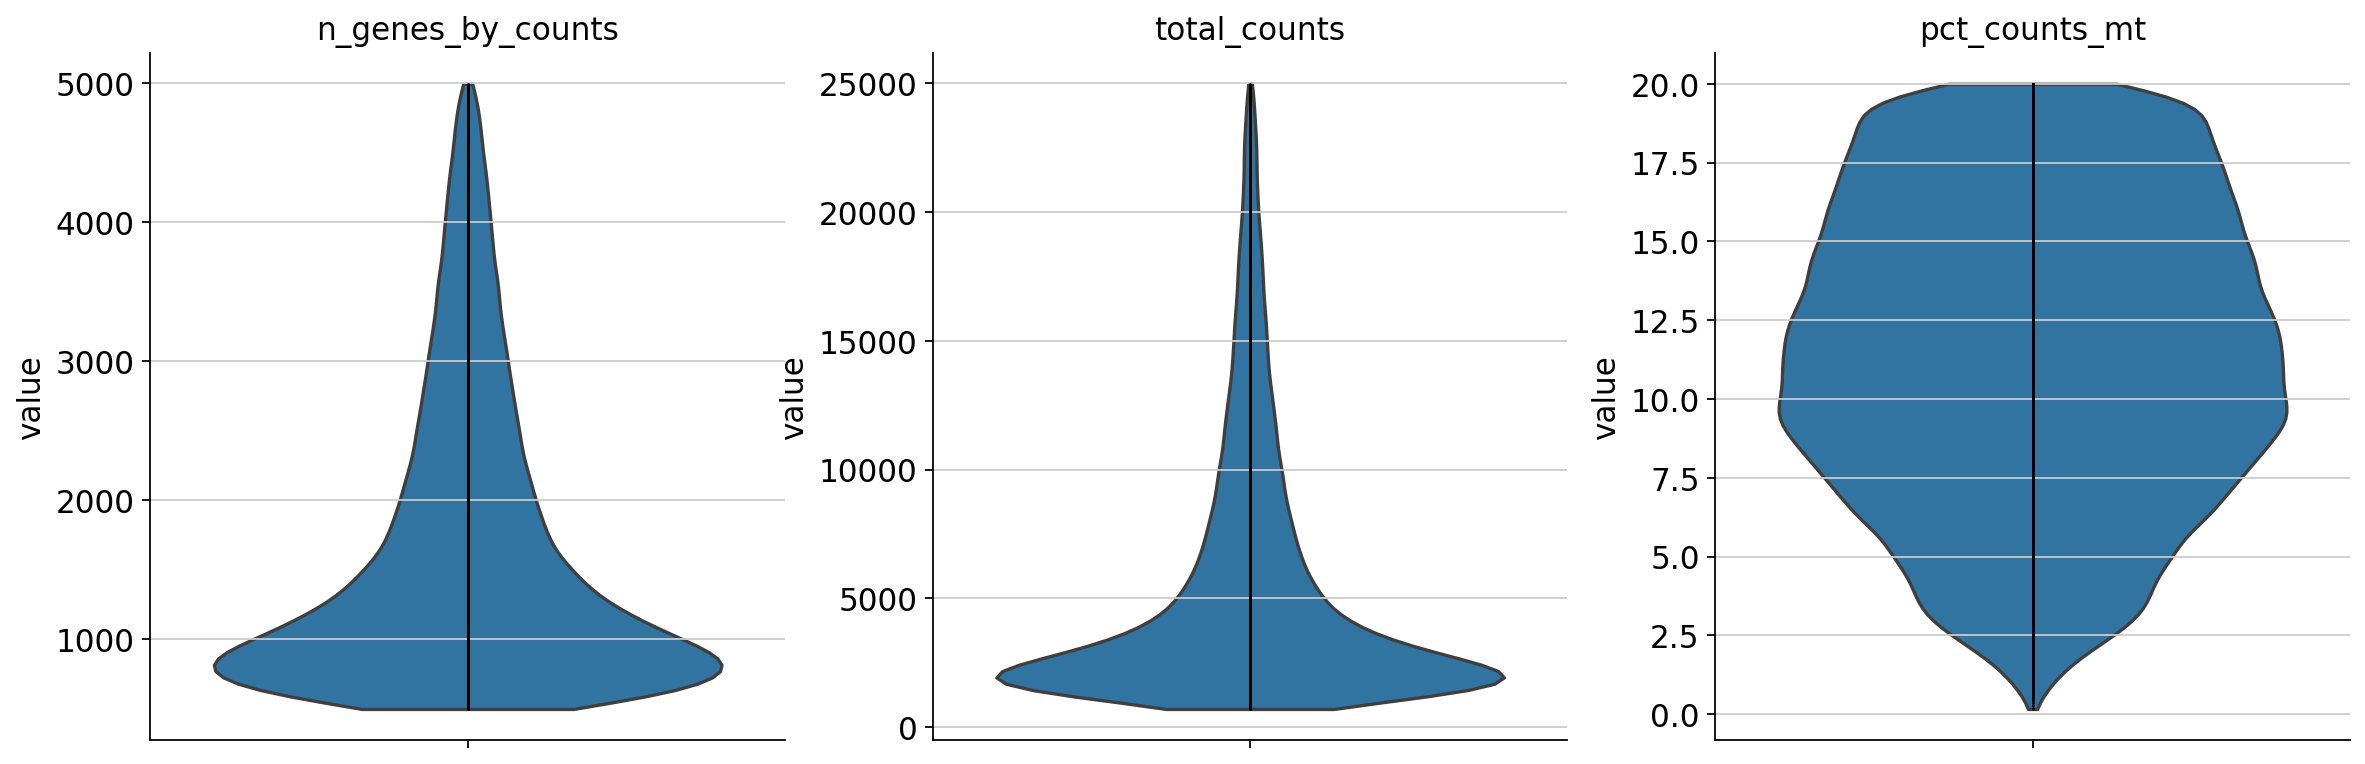

In [14]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.0, multi_panel=True)

## 2. Integrating Samples

#### Normalization & Logarithmization:

In [24]:
print(str(adata.X[0,:].sum()))

6555.0


In [25]:
# Log normalization scaled up to 10000
print("Before normalization, the sum of first row of X: " + str(adata.X[0,:].sum()))
sc.pp.normalize_total(adata, target_sum=1e4)
print("After normalization, the sum of first row of X: " + str(adata.X[0,:].sum()))


Before normalization, the sum of first row of X: 6555.0


/home/xinghua/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell


/home/xinghua/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


    finished (0:00:00)
After normalization, the sum of first row of X: 9999.8955


In [26]:
print("Before log, the sum of first row of X: " + str(adata.X[0,:].sum()))
# Logarithmize adata
sc.pp.log1p(adata)
print("After log, the sum of first row of X: " + str(adata.X[0,:].sum()))

Before log, the sum of first row of X: 9999.8955
After log, the sum of first row of X: 2997.0154


### load cell cycle markers and score cells for cell cycle


In [ ]:
# load cell cycle markers and score cells for cell cycle
cell_cycle_genes = [x.strip() for x in open('/home/data/PanCanSC/CRC/GEO/GSE205506/cell_cycle_genes.txt')]  
s_genes = cell_cycle_genes[:43]

In [1]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

NameError: name 'sc' is not defined

### Keep track of original adata and update adata.X to  high variance genes only

In [17]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
print("adata dimensions of high variance genes: " + str(adata.shape))

adata dimensions of high variance genes: (65352, 2061)


In [ ]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

In [ ]:
sc.tl.leiden(adata)
cluster_labels = adata.obs['leiden']

In [ ]:
# load/find cell cycle markers: T-test/T-cells
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
# Scoring cells for cell cycle
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

In [ ]:
# Scale the counts to regress out cell cycle effect
sc.pp.scale(adata, max_value=10)


In [ ]:
adata.obs.columns

## 3. Unsupervised cell clustering & identification of major cell types

In [ ]:
# 2000 highly variable genes w/ 'vst' method?
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
#sc.pp.highly_variable_genes(adata, flavor='vst', n_top_genes=2000)

In [ ]:
adata.raw = adata
highly_variable_genes = adata.var['highly_variable']

# Filter out genes that aren't highly variable
adata = adata[:, highly_variable_genes]

In [ ]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
adata.obs_names_make_unique

In [ ]:
sc.pp.scale(adata, max_value=10)  # why scale again? and why max_value=10?

In [ ]:
# Identifying 30 PCs(principle components)
sc.pp.pca(adata, n_comps=30)
pcs = adata.obsm['X_pca']

In [ ]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

In [ ]:
sc.tl.umap(adata)
sc.tl.leiden(adata)
#sc.pl.umap(adata)

In [ ]:
adata.obs

In [ ]:
sc.pl.umap(adata, color='leiden')